<div style="text-align: right"> Manuel Veras </div>

<left>Econometría Financiera</left> 
<br>

<h2><center>Ejercicios Práctica - Tarea #2</center></h2>


**ProShares Hedge Replication ETF [UV6939].**

## Setup

In [8]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import warnings
sns.set()
from statsmodels.regression.rolling import RollingOLS

from portfolio import *


pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Data

In [2]:
path = 'hedge_fund_replication_data.xlsx'
df_hedge_rep = pd.read_excel(path, sheet_name='HEDGE-REP').set_index('date')
df_merrill_facs = pd.read_excel(path, sheet_name='MERRILL-FACS').set_index('date')
df_multi_asset = pd.read_excel(path, sheet_name='MULTI-ASSET').set_index('date')

## Ejercicios

### 1 El producto de ProShares ETF

    ***2.Hedge Funds***
    
    (a) Usando solo información de caso, ¿cuáles son las dos medidas por las cuales los hedge funds son una inversión atractiva?
    
    Como se puede ver en el Exhibit , slide 9-10, el indice HFRI tiene un Sharpe RAtio mas alto que S&P500 (.84 vs .41), asi como un drawdown significativamente mas pequeño. El Slide 7 tambien resalta que HFRI no esta perfectamente correlacionado con los activos equities (acciones) y bonds (bonos), por lo que provee beneficios de diversificación a nivel de construcción de portafolio.

<br><br><br>
    ***3.Benchmarks***
    
    
    a)	¿Qué tan bien el Merril Lynch Factor Model (MLFM) replica el índice HFRI?
    
    Slide 18 muestra que MLFM tiene una correlación de 0.90 hasta 2013.
    
    b)	¿En que factores el Merrill Lynch Factor Model tiene la mayor beta?
    
    Por mucho, el factor con maypr beta son los t-bills. Esto es verdad durante el 2013 y el 2014. Ver Exhibit 1, slides 19-20.
    

    
    


### 2 Analyzing the Data

Utilice el archivo “hedge_fund_replication.xlsx”. El archivo tiene data mensual de los índices financieros y ETFs septiembre 2020.

1. Para cada uno de los activos en el sheet “HEDGE-REP”, calcule el exceso de retorno substrayendo el índice USGG3M en cada periodo

	a. Media de Retornos
    
	b. Volatilidad de los Retornos.
    
	c. Sharpe Ratio
    
	d. Market Beta/Beta Mercado (basado en SPY).
    
	e. Treynor Ratio (que utiliza el beta calculado más arriba).
    
	f. Information Ratio, (basado en la regresión utilizada para calcular el beta de mercado)

Anualice los estos estadísticos. (Multiplique las medias por 12, volatilidad por √12, no multiplique los betas por nada).


In [3]:
# Calculemos los excesos de retorno

hedge_rep_portfolio_names = ['HFRIFWI Index', 'MLEIFCTR Index',
    'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity', 'SPY US Equity']

# Substrayendo tasa libre de riesgo:
USGG3M = df_merrill_facs['USGG3M Index']
df_hedge_rep_excess = df_hedge_rep.subtract(USGG3M, axis=0)


In [4]:
Performance = performanceMetrics(df_hedge_rep_excess,12)
Performance.style.set_caption('Tabla 1: 2011-2020 Resumen Estadístico 1(Anualizado)')

,Mean,Vol,Sharpe,Min,Max
HFRIFWI Index,0.027555,0.058778,0.468798,-0.090835,0.045150
MLEIFCTR Index,0.022702,0.051485,0.440951,-0.053285,0.043606
MLEIFCTX Index,0.021002,0.051279,0.409559,-0.052435,0.043332
HDG US Equity,0.012126,0.054712,0.221634,-0.059242,0.050545
QAI US Equity,0.017644,0.045737,0.385773,-0.056397,0.034129
SPY US Equity,0.124200,0.134972,0.920189,-0.124693,0.126918


In [5]:
OLS_METRICS = get_ols_metrics(df_hedge_rep_excess[['SPY US Equity']],df_hedge_rep_excess,12)
OLS_METRICS.style.set_caption('Tabla 1: 2011-2020 Resumen Estadístico 2')

,alpha,SPY US Equity,r-squared,Treynor Ratio,Mkt Corr,Info Ratio
HFRIFWI Index,-0.021066,0.391476,0.808117,0.070387,0.898953,-0.818200
MLEIFCTR Index,-0.021445,0.355453,0.868345,0.063869,0.931850,-1.147951
MLEIFCTX Index,-0.022954,0.353912,0.867764,0.059342,0.931538,-1.230964
HDG US Equity,-0.034889,0.368689,0.830166,0.032890,0.911135,-1.547351
QAI US Equity,-0.018232,0.288854,0.726634,0.061083,0.852428,-0.762411
SPY US Equity,0.000000,1.000000,1.000000,0.124200,1.000000,nan


In [6]:
df_hedge_rep_excess_post2013 = df_hedge_rep_excess['2014':] # Cortando muestra empezando desde 2014 (obviando 2013)

Performance = performanceMetrics(df_hedge_rep_excess_post2013,12)
Performance.style.set_caption('Tabla 3: 2014-2020 Resumen Estadístico 1(Anualizado)')

,Mean,Vol,Sharpe,Min,Max
HFRIFWI Index,0.024428,0.060133,0.406225,-0.090835,0.045150
MLEIFCTR Index,0.020928,0.050503,0.414398,-0.053285,0.040235
MLEIFCTX Index,0.019179,0.050256,0.381618,-0.052435,0.039679
HDG US Equity,0.009340,0.052026,0.179530,-0.059242,0.042282
QAI US Equity,0.011021,0.047180,0.233595,-0.056397,0.034129
SPY US Equity,0.109342,0.137528,0.795048,-0.124693,0.126918


In [7]:
OLS_METRICS = get_ols_metrics(df_hedge_rep_excess_post2013[['SPY US Equity']],df_hedge_rep_excess_post2013,12)
OLS_METRICS.style.set_caption('Tabla 4: 2014-2020 Resumen Estadístico 2')

,alpha,SPY US Equity,r-squared,Treynor Ratio,Mkt Corr,Info Ratio
HFRIFWI Index,-0.018724,0.394651,0.814666,0.061897,0.902588,-0.723283
MLEIFCTR Index,-0.016923,0.346175,0.888677,0.060456,0.942697,-1.004319
MLEIFCTX Index,-0.018474,0.344361,0.888030,0.055694,0.942354,-1.098559
HDG US Equity,-0.029448,0.354746,0.879369,0.026330,0.937747,-1.629687
QAI US Equity,-0.021823,0.300377,0.766652,0.036691,0.875586,-0.957514
SPY US Equity,0.000000,1.000000,1.000000,0.109342,1.000000,nan


2.	Rendimiento Relativo.

a.	¿Cómo podemos evaluar el rendimiento de estos activos despues del caso en 2013?

b.	¿Cómo HDG mejora los resultados de QAI?

c.	¿Cómo se comparan con el S&P500 (SPY)?


**Solución: Primero, notamos algunas cosas sobre la muestra completa:

- HDG tiene una media baja, alta volatilidad, y un SR por debajo de sus competidores, QAI, sobre la muestra completa. Además, QAI, tiene una correlación mas baja con S&P 500 (SPY).

- El indeice HFRI tiene un SR mas alto que los indices ML, y un SR mas grande que los replicadores, HDG y QAI.


En los años años posteriores 2014-2020 notamos lo siguiente:

- Los Sharpe Ratios, market betas, correlacion son similares como en el muetra completa.
- QAI tiene mejore resultados que HDG desde 2014 tanto exceso de retornos como Sharpe Ratio.
- El índice MLEIFCTX continua haciendo un buen trabajo siguiendo las propiedades de MLEIFCTR, por lo menos obsevando la media, volatilidad y market beta de los retornos
- SPY tiene mayor exceso de retornos que cualquier otro instrumento o índice, aunque tiene una volatilidad mucho mayor. Aun así, SPY tiene el mayor Sharpe Ratio.

3. Para las series de tiempo en el sheet “MERRILL-FACS”. Incluya intercepto. Reporte los siguientes estadísticos: 

<br><br>
$$r_t^{hfri} = \alpha^{merr} + x_t^{merr} \beta^{merr} +\epsilon_t^{merr}$$
$$r_t^{hfri->merr} = \hat{\alpha^{merr}} + x_t^{merr} \hat{\beta^{merr}} +\epsilon_t^{merr}$$
 
Note que la segunda ecuación es solo nuestra notación para la replicación. 

a. Reporte el intercepto y los betas.

b. ¿Son estos betas tamaño de posiciones reales, o acaso necesitan de posicione long-short grandes?

c. Reporte el R-cuadrado. 

d. Reporte la volatilidad de ε^merr. (Tracking Error/Error de Seguimiento).


In [50]:
# Vamos a utilizar el statsmodels package de python


#Definimos y
y = (df_hedge_rep['HFRIFWI Index'])

# Definimos los factores X y utilizamos .add_constant() para agregar constante a la regresión. 
# Si no utilizamos .add_constant la regresión no tendrá constante.
X = sm.add_constant(df_merrill_facs)
static_model = sm.OLS(y,X).fit()

In [51]:
# utilizamos el comando .params.to_frame() para mostrar parametros de regresión 
static_model.params.to_frame('Parametros de la Regresión')

,Parametros de la Regresión
const,-0.0001
SPY US Equity,0.1389
USGG3M Index,0.1950
EEM US Equity,0.0769
EFA US Equity,0.0852
EUO US Equity,0.0287
IWM US Equity,0.0854


In [52]:
# R Cuadrado de la Regresión 
round(static_model.rsquared,4)

0.8714

In [53]:
# utilizamos .resid.std() para encontrar la desviación estandar de los residuos y analuzamos. 
round(static_model.resid.std() * np.sqrt(12),4)

0.021

4. Ahora vamos a evaluar el rendimiento fuera de muestra (out of sample performance).

Para los valores t desde enero del 2015 hasta septiembre 2020, haga lo siguiente:

	Use la data hasta t-1 para estimar la regresión del ejercicio 6. Esto nos va de los estimados en el tiempo-t de los parámetros de la regresión, α ̂_t^merr y β ̂_t^merr  .


	Use los parámetros estimados de la regresión, así como los valores x_t^merr, para calcular el valor replicado en el tiempo-t  eso es, con respecto a los estimados de la regresión, construya el “out-of-sample” (OOS). 

$$r_t^{hfri->merr:OOS} = \hat{\alpha_t^{merr}} + (x_t^{merr})^{'} \hat{\beta_t^{merr}}$$

In [54]:
# Utilzaremos la fución rolling regression para realizar regresiones 

# Primero determinaremos la cantidad de meses de data entre 2011 hasta 2015.

w = len(y[:'2014'])
print('Cantidad de Meses: ',w)

Cantidad de Meses:  42


In [55]:
# utilizamos la función RollingOLS sobre la misma data utilizada. 

model = RollingOLS(y,X,window=w)
rolling_betas = model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,,
2011-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-05-31,-0.0018,0.0765,1.3365,0.1044,0.1194,0.0481,0.1291
2020-06-30,-0.0013,0.0658,1.0224,0.1149,0.1139,0.0506,0.1339
2020-07-31,-0.0011,0.1164,0.8402,0.1310,0.0460,0.0207,0.1288


In [56]:
rep_IS

date
2011-07-31       NaN
2011-08-31       NaN
2011-09-30       NaN
2011-10-31       NaN
2011-11-30       NaN
               ...  
2020-05-31    0.2258
2020-06-30    0.1789
2020-07-31    0.2326
2020-08-31    0.2441
2020-09-30   -0.1311
Length: 111, dtype: float64

In [57]:
# Mostrando Resultados 

# replicación rolling In Sample
rep_IS = (rolling_betas * X).sum(axis=1,skipna=False)

# Replicación rolling Out of Sample
rep_OOS = (rolling_betas.shift() * X).sum(axis=1,skipna=False)
replication = df_hedge_rep[['HFRIFWI Index']].copy()

# Creamos columunas
replication['Static-IS-Int'] = static_model.fittedvalues
replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS
replication

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
date,,,,
2011-07-31,0.0023,-0.0082,NaN,NaN
2011-08-31,-0.0321,-0.0301,NaN,NaN
2011-09-30,-0.0389,-0.0382,NaN,NaN
2011-10-31,0.0269,0.0467,NaN,NaN
2011-11-30,-0.0135,-0.0028,NaN,NaN
...,...,...,...,...
2020-05-31,0.0238,0.0183,0.0188,0.0171
2020-06-30,0.0199,0.0126,0.0149,0.0140
2020-07-31,0.0297,0.0160,0.0194,0.0137


In [58]:
# Correlación entre HFRIFWI y las diferentes metodologias de replicas utilizadas. Esto lo podemos utilizar para identificar que
# estrategia de estimación mantienen una mejor correlación con el objetivo a replicar HFRIFWI. 
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
HFRIFWI Index,1.0000,0.9335,0.9751,0.9314
Static-IS-Int,0.9335,1.0000,0.9881,0.9922
Rolling-IS-Int,0.9751,0.9881,1.0000,0.9843
Rolling-OOS-Int,0.9314,0.9922,0.9843,1.0000


<AxesSubplot:xlabel='date'>

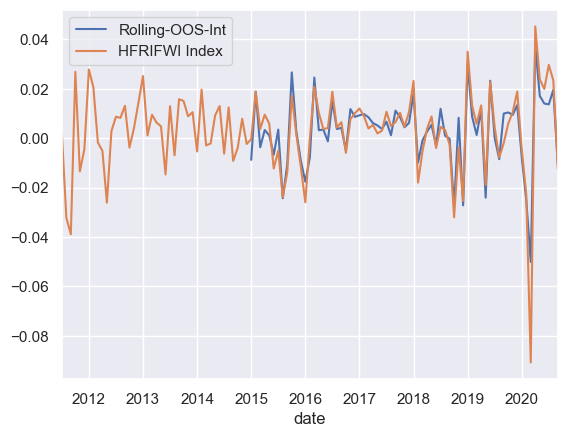

In [62]:
replication[['Rolling-OOS-Int','HFRIFWI Index']].plot()